# Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torchvision import models

In [2]:
# Verificando se tem GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Transformações

In [3]:
# Configurando as transformações a serem utilizadas nos dados + data augmentation para o treinamento
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Carregando os dados e criando os DataLoaders

In [4]:
# Carregando os datasets
train_dataset = ImageFolder(root='./split_data/train', transform=train_transform)
val_dataset = ImageFolder(root='./split_data/val', transform=val_test_transform)
test_dataset = ImageFolder(root='./split_data/test', transform=val_test_transform)

# Configuração do DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Mostrando algumas imagens do conjunto de treinamento

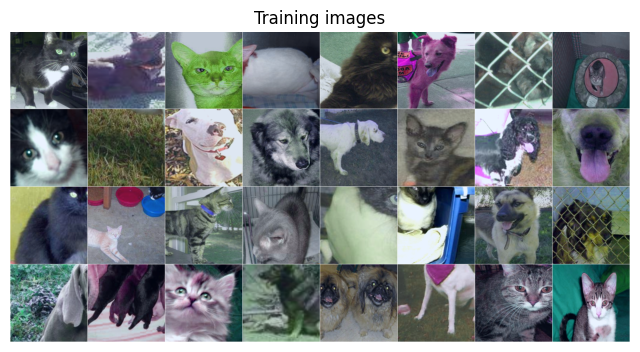

In [5]:
%matplotlib inline

for images, labels in train_loader:
    break

plt.figure(figsize=(8,8))
plt.axis('off')
plt.title('Training images')
plt.imshow(np.transpose(make_grid(
    images[:64],
    padding=1,
    pad_value=1.0,
    normalize=True),
    (1, 2, 0)))

# Modelo

In [6]:
model = models.resnet50(weights='DEFAULT')
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model.fc.in_features, 1),
    nn.Sigmoid()
)

# Treinando o Modelo

In [7]:
def compute_accuracy(model, dataloader):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = model.eval()

    correct = 0.0
    total_examples = 0

    for idx, (features, labels) in enumerate(dataloader):

        features = features.to(device)
        labels = labels.to(device)

        with torch.inference_mode():
            logits = model(features)

        predictions = (logits >= 0.5) # threshold function

        compare = (labels == predictions.squeeze())
        correct += torch.sum(compare)
        total_examples += len(compare)

    return correct / total_examples

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device=device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.2)

criterion = nn.BCELoss() # Binary cross-entropy for binary classification

num_epochs = 20

loss_list = []
train_acc_list, val_acc_list = [], []
best_accuracy = 0.0
for epoch in range(num_epochs):

    model = model.train()
    for batch_idx, (features, labels) in enumerate(train_loader):

        features = features.to(device)
        labels = labels.to(device)

        logits = model(features)

        loss = criterion(logits.squeeze(), labels.float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if not batch_idx % 250:
            print(
                f"Epoch: {epoch+1:03d}/{num_epochs:03d}"
                f" | Batch {batch_idx:03d}/{len(train_loader):03d}"
                f" | Train Loss: {loss:.2f}"
            )

        loss_list.append(loss.item())

    train_acc = compute_accuracy(model, train_loader)
    val_acc = compute_accuracy(model, val_loader)
    print(f'Train Acc {train_acc*100:.2f}% | Val Acc {val_acc*100:.2f}%')
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    scheduler.step(val_acc)

    if val_acc > best_accuracy:
        best_accuracy = val_acc
        torch.save(model.state_dict(), "melhor_modelo_resnet.pth")

Epoch: 001/020 | Batch 000/547 | Train Loss: 0.67
Epoch: 001/020 | Batch 250/547 | Train Loss: 0.16
Epoch: 001/020 | Batch 500/547 | Train Loss: 0.05
Train Acc 96.14% | Val Acc 99.07%
Epoch: 002/020 | Batch 000/547 | Train Loss: 0.41
Epoch: 002/020 | Batch 250/547 | Train Loss: 0.35
Epoch: 002/020 | Batch 500/547 | Train Loss: 0.13
Train Acc 96.68% | Val Acc 99.23%
Epoch: 003/020 | Batch 000/547 | Train Loss: 0.05
Epoch: 003/020 | Batch 250/547 | Train Loss: 0.21
Epoch: 003/020 | Batch 500/547 | Train Loss: 0.07
Train Acc 97.36% | Val Acc 99.31%
Epoch: 004/020 | Batch 000/547 | Train Loss: 0.14
Epoch: 004/020 | Batch 250/547 | Train Loss: 0.09
Epoch: 004/020 | Batch 500/547 | Train Loss: 0.03
Train Acc 96.62% | Val Acc 99.09%
Epoch: 005/020 | Batch 000/547 | Train Loss: 0.07
Epoch: 005/020 | Batch 250/547 | Train Loss: 0.03
Epoch: 005/020 | Batch 500/547 | Train Loss: 0.06
Train Acc 97.16% | Val Acc 99.25%
Epoch: 006/020 | Batch 000/547 | Train Loss: 0.01
Epoch: 006/020 | Batch 250/547

# Avaliando os resultados

In [9]:
# Carregando o melhor modelo para calcular as acurácias finais
model.load_state_dict(torch.load("melhor_modelo_resnet.pth"))

train_acc = compute_accuracy(model, train_loader)
val_acc = compute_accuracy(model, val_loader)
test_acc = compute_accuracy(model, test_loader)

print(f'Train Acc {train_acc*100:.2f}%')
print(f'Val Acc {val_acc*100:.2f}%')
print(f'Test Acc {test_acc*100:.2f}%')

C:\Users\Felipe\AppData\Local\Temp\ipykernel_62672\451527726.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("melhor_modelo_resnet.pth")

Train Acc 98.03%
Val Acc 99.60%
Test Acc 99.33%


# Plotando a função perda

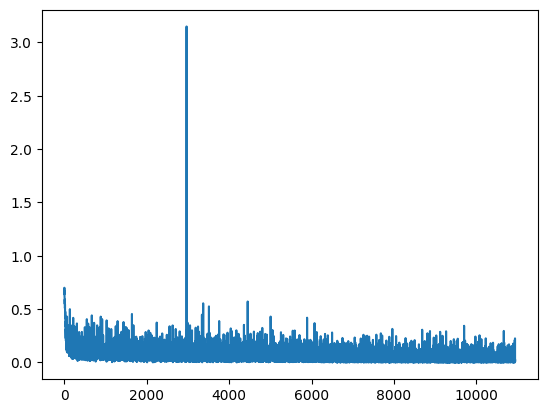

In [10]:
plt.plot(loss_list)

# Plotando a acurácia do modelo (treinamento e validação) ao longo das épocas

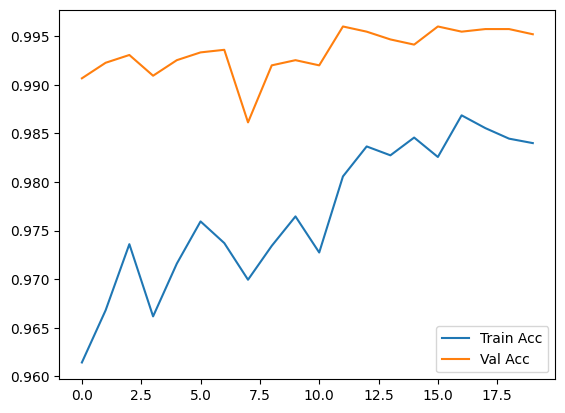

In [11]:
# Passando para o cpu

train_acc_list_cpu = []
for elemento in train_acc_list:
    elemento = elemento.to('cpu')
    train_acc_list_cpu.append(elemento)

val_acc_list_cpu = []
for elemento in val_acc_list:
    elemento = elemento.to('cpu')
    val_acc_list_cpu.append(elemento)


plt.plot(train_acc_list_cpu, label = 'Train Acc')
plt.plot(val_acc_list_cpu, label = 'Val Acc')
plt.legend()
plt.show()